### 必要なモジュールのimport

In [41]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score, mean_squared_error
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [42]:
# データの読み込み(02_data_preparation.ipynbで作成したデータ)
train = pd.read_csv('../data/processed/processed20240627_train.csv')
# train_ori = pd.read_csv('../data/processed/processed20240627_train.csv')
test = pd.read_csv('../data/processed/processed20240627_test.csv')

## targetの分布の確認

In [43]:
# # targetの正規化
# scaler = MinMaxScaler()
# train['target'] = scaler.fit_transform(train[['target']])

C:\Users\kento.nishino.ek\AppData\Local\Temp\ipykernel_17452\2946955093.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['target'])


<Axes: xlabel='target', ylabel='Density'>

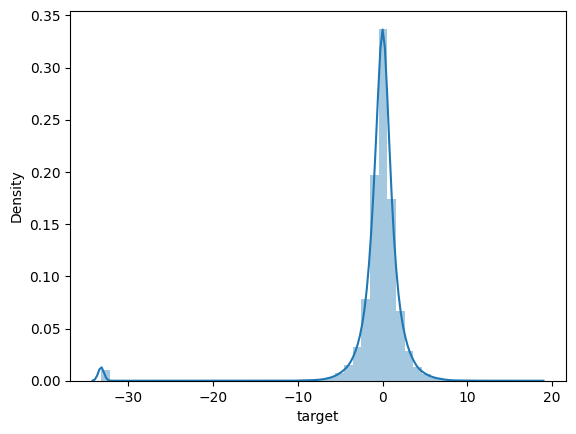

In [44]:
# 目的変数の分布を確認
sns.distplot(train['target'])

<Axes: xlabel='target'>

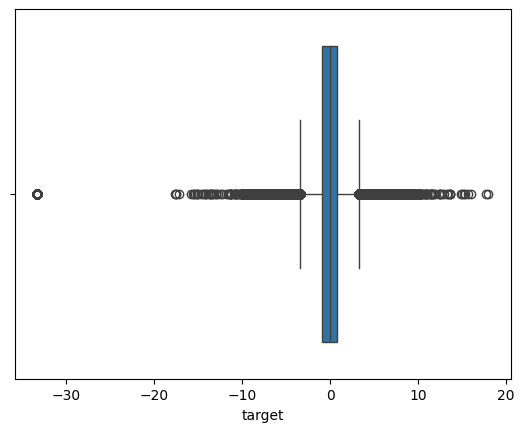

In [45]:
# 箱ひげ図
sns.boxplot(x='target', data=train)

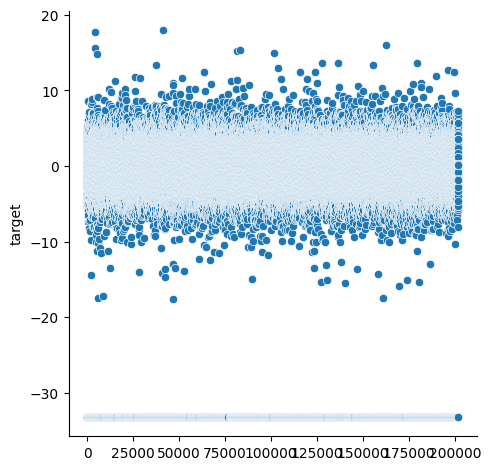

In [46]:
sns.relplot(data=train['target'])

ここまでグラフを見てみると特に0.1未満の数字の部分が特に外れ値であると考えられます。   
今回のコンペの評価指標がRMSEとなっていることもあり、こうした極端な外れ値に対してもきちんと予測できないと精度は悪化してしまうため外れ値のフラグを立ててそれを特徴量ととして実装していきましょう。

In [47]:
# 最小値を算出
train['target'].min()

-33.21928095

In [48]:
# ロイヤリティの値が最小値であるデータの量をカウント
len(train[train['target'] == 0.0])

1630

In [49]:
# 最大値を算出
train['target'].max()

17.9650684

In [50]:
# ロイヤリティの値が最大値であるデータの量をカウント
len(train[train['target'] == 1.0])

117

In [51]:
# カウント範囲を設定
range_min = 0.5
range_max = train['target'].min() - 0.1  # -10より小さい最小値を設定
ranges = np.arange(range_max, range_min, 0.1)  # 0.1刻みで範囲を生成

# カウントを行う
counts = [len(train[train['target'] < r]) for r in ranges]

# データフレームにまとめる
count_df = pd.DataFrame({'範囲': ranges, 'データの個数': counts})
count_df

,範囲,データの個数
0,-33.319281,0
1,-33.219281,0
2,-33.119281,2207
3,-33.019281,2207
4,-32.919281,2207
...,...,...
334,0.080719,110289
335,0.180719,117338
336,0.280719,124176
337,0.380719,130721


ロイヤリティの値が最小値であるデータの個数が2207に対して最大値であるデータの量は1となっており、明らかに-33.21928095の値が異常であることが考えられます(仮説：長期滞納者などをひとまとめにしている？)

また0.0から0.1刻みにそれ未満のデータ数がどれだけ存在するかを調べてみると0.5未満までは最小値と同じデータ数になるため、明らかに0.0の値が断絶していることが確認できます。  

## XGboostモデルの作成

In [52]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [53]:

# 特徴量と目的変数の設定
X = train.drop(columns=['target'])
y = train['target']


In [54]:
# 日付データの変換
if 'first_active_month' in X.columns:
    X['first_active_month'] = pd.to_datetime(X['first_active_month'])
    X['first_active_month_year'] = X['first_active_month'].dt.year
    X['first_active_month_month'] = X['first_active_month'].dt.month
    X = X.drop(columns=['first_active_month'])

In [55]:
# カテゴリカルデータの頻度ベースエンコーディング
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    freq_encoding = X[col].value_counts(normalize=True)
    X[col + '_freq'] = X[col].map(freq_encoding)
X = X.drop(columns=categorical_cols)

In [56]:
# # 欠損値の処理
# X = X.fillna(-999)
# test_data = test_data.fillna(-999)


In [57]:
def objective(trial):
    # ハイパーパラメータの設定
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_loguniform('eta', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10),
        'seed': 42
    }

    # KFoldクロスバリデーションの設定
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    # 各分割での学習と評価
    for fold, (train_index, valid_index) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # DMatrixに変換
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        
        # モデルの訓練
        model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(dvalid, 'valid')], verbose_eval=False)
        
        # モデルを保存
        with open(f'model_fold_{fold}.pkl', 'wb') as f:
            pickle.dump(model, f)
        
        # 予測と評価
        preds = model.predict(dvalid)
        rmse = mean_squared_error(y_valid, preds, squared=False)
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

In [58]:
# Optunaのスタディを作成し、最適化を実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-27 16:15:56,567] A new study created in memory with name: no-name-222959c7-8225-476b-93af-7762bf618d13
[I 2024-06-27 16:17:10,721] Trial 0 finished with value: 3.6613309589169205 and parameters: {'eta': 0.018819941673638985, 'max_depth': 6, 'min_child_weight': 3.230297847671618, 'subsample': 0.9022163701999315, 'colsample_bytree': 0.84276573839571, 'lambda': 0.8774505661876907, 'alpha': 0.005979854916203919}. Best is trial 0 with value: 3.6613309589169205.
[I 2024-06-27 16:17:41,127] Trial 1 finished with value: 3.666372266780953 and parameters: {'eta': 0.056739033623143344, 'max_depth': 6, 'min_child_weight': 7.420321351203355, 'subsample': 0.6864717338387576, 'colsample_bytree': 0.586347692602597, 'lambda': 0.002623914613116293, 'alpha': 0.14977318507262502}. Best is trial 0 with value: 3.6613309589169205.
[I 2024-06-27 16:18:11,214] Trial 2 finished with value: 3.6679806626756126 and parameters: {'eta': 0.062211991647789934, 'max_depth': 5, 'min_child_weight': 2.103439293

In [ ]:
# 最適なハイパーパラメータを取得
best_params = study.best_params
print("Best parameters: ", best_params)

Best parameters:  {'eta': 0.014816918885524066, 'max_depth': 5, 'min_child_weight': 3.500565860046261, 'subsample': 0.8998977582346174, 'colsample_bytree': 0.5805263456544666, 'lambda': 0.010567878870808194, 'alpha': 3.289320840205314}


In [ ]:
# KFoldクロスバリデーションでの学習と予測
kf = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = np.zeros(len(test))

In [ ]:
# 日付データの変換
def preprocess_data(df):
    if 'first_active_month' in df.columns:
        df['first_active_month'] = pd.to_datetime(df['first_active_month'])
        df['first_active_month_year'] = df['first_active_month'].dt.year
        df['first_active_month_month'] = df['first_active_month'].dt.month
        df = df.drop(columns=['first_active_month'])
    
    # カテゴリカルデータの頻度ベースエンコーディング
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        freq_encoding = df[col].value_counts(normalize=True)
        df[col + '_freq'] = df[col].map(freq_encoding)
    df = df.drop(columns=categorical_cols)
    
    return df

In [ ]:
test = preprocess_data(test)

In [ ]:
# 各分割での学習と予測の集約
for train_index, valid_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # DMatrixに変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    dtest = xgb.DMatrix(test)
    
    # モデルの訓練
    model = xgb.train(best_params, dtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(dvalid, 'valid')], verbose_eval=10)
    
    # 予測の集約
    predictions += model.predict(dtest) / kf.n_splits

[0]	valid-rmse:0.07565
[10]	valid-rmse:0.07504
[20]	valid-rmse:0.07455
[30]	valid-rmse:0.07416
[40]	valid-rmse:0.07385
[50]	valid-rmse:0.07360
[60]	valid-rmse:0.07339
[70]	valid-rmse:0.07323
[80]	valid-rmse:0.07309
[90]	valid-rmse:0.07297
[100]	valid-rmse:0.07287
[110]	valid-rmse:0.07278
[120]	valid-rmse:0.07272
[130]	valid-rmse:0.07266
[140]	valid-rmse:0.07260
[150]	valid-rmse:0.07256
[160]	valid-rmse:0.07251
[170]	valid-rmse:0.07248
[180]	valid-rmse:0.07245
[190]	valid-rmse:0.07241
[200]	valid-rmse:0.07238
[210]	valid-rmse:0.07236
[220]	valid-rmse:0.07234
[230]	valid-rmse:0.07231
[240]	valid-rmse:0.07230
[250]	valid-rmse:0.07228
[260]	valid-rmse:0.07226
[270]	valid-rmse:0.07224
[280]	valid-rmse:0.07222
[290]	valid-rmse:0.07221
[300]	valid-rmse:0.07220
[310]	valid-rmse:0.07218
[320]	valid-rmse:0.07217
[330]	valid-rmse:0.07216
[340]	valid-rmse:0.07215
[350]	valid-rmse:0.07214
[360]	valid-rmse:0.07213
[370]	valid-rmse:0.07212
[380]	valid-rmse:0.07211
[390]	valid-rmse:0.07210
[400]	valid

## 提出ファイルの作成

In [ ]:
# 補正(外れ値あり)
target_max = 17.9650684
target_min = -33.21928095

# 数値の補正
pred_scaled = predictions * (target_max - target_min) + target_min

In [ ]:
# # 予測値の逆変換
# predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))
# # predictions_original_scaleには目的変数の元のスケールでの予測値が格納される

C:\Users\kento.nishino.ek\AppData\Local\Temp\ipykernel_17452\240245167.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_scaled)


<Axes: ylabel='Density'>

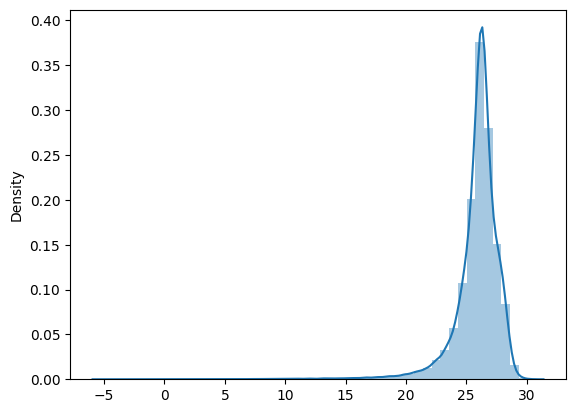

In [ ]:
# 目的変数の分布を確認
# sns.distplot(predictions_original_scale)
sns.distplot(pred_scaled)

In [ ]:
test.head()

,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_day_mean,hist_purchase_day_max,hist_purchase_day_min,hist_purchase_day_std,hist_purchase_dayofweek_mean,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_dayofweek_std,hist_is_weekend_mean,hist_is_weekend_max,hist_is_weekend_min,hist_is_weekend_std,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_day_mean,auth_purchase_day_max,auth_purchase_day_min,auth_purchase_day_std,auth_purchase_dayofweek_mean,auth_purchase_dayofweek_max,auth_purchase_dayofweek_min,auth_purchase_dayofweek_std,auth_is_weekend_mean,auth_is_weekend_max,auth_is_weekend_min,auth_is_weekend_std,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_day_mean,new_purchase_day_max,new_purchase_day_min,new_purchase_day_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_is_weekend_mean,new_is_weekend_max,new_is_weekend_min,new_is_weekend_std,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,install

In [ ]:
test = pd.read_csv('../data/processed/processed20240627_test.csv')

In [ ]:
# 提出用ファイルの作成
sub_df = pd.DataFrame({'card_id': test['card_id'].values})
sub_df['target'] = pred_scaled
sub_df.to_csv('submission.csv', index=False)

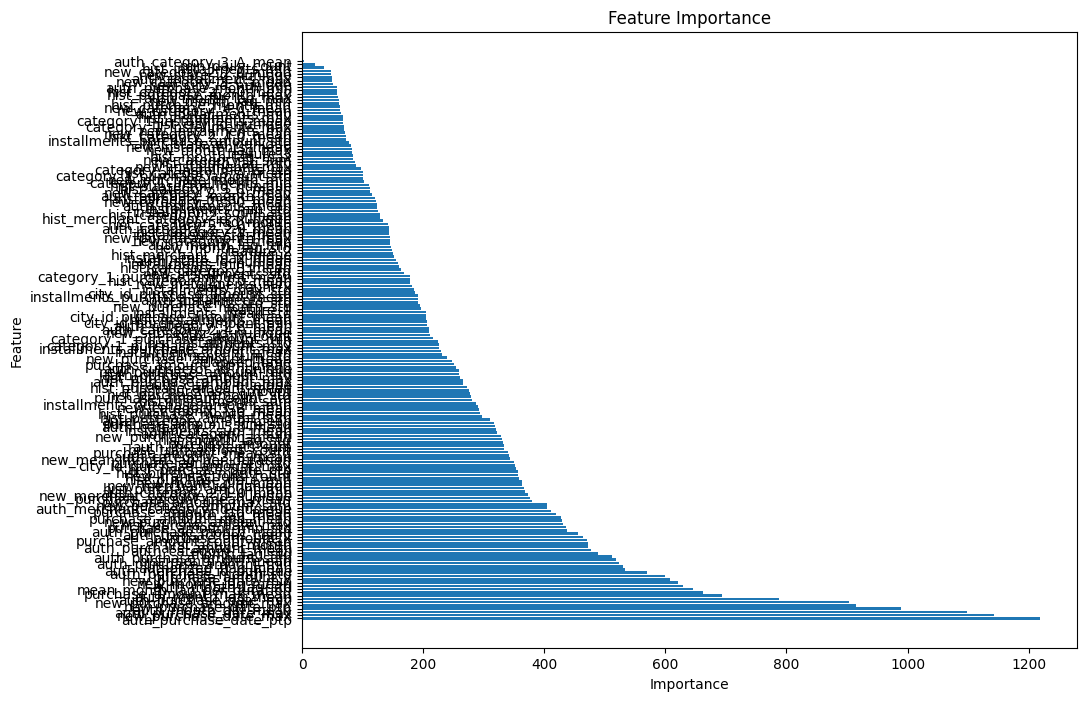

In [ ]:
# 特徴量重要度の可視化
importance = model.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()